# 对于连续5个脉冲给出器件的响应电流 

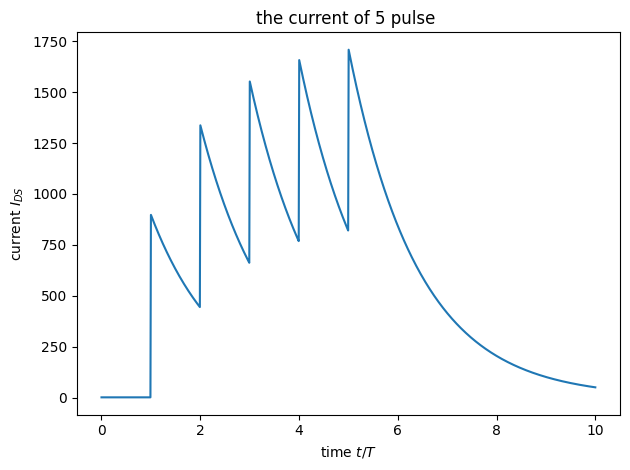

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# —— 参数设置 —— 
kappa = 897     # 单次脉冲电流增量
tau   = 1.704     # 弛豫时间常数
beta  = 1     # 拉伸指数
T     = 0.5     # 时间步长
I0    = 1     # 静态基线电流

# 5 个连续光脉冲到达时刻（以时间步为单位）
t_pulses = np.array([1, 2, 3, 4, 5])

# 定义观测时刻向量
t = np.linspace(0, t_pulses[-1] + 5, 1000)

# 初始化输出电流数组
I_DS = np.zeros_like(t)

# 计算 I_DS(t) 在每个观测时刻
for idx, t_n in enumerate(t):
    arrived = t_n >= t_pulses
    if arrived.any():
        contributions = kappa * np.exp(-(((t_n - t_pulses[arrived]) * T) / tau) ** beta)
        delta_I = contributions.sum()
    else:
        delta_I = 0.0
    I_DS[idx] = I0 + delta_I

# 绘图
plt.figure()
plt.plot(t, I_DS)
plt.xlabel("time $t/T$")
plt.ylabel("current $I_{DS}$")
plt.title("the current of 5 pulse ")
plt.tight_layout()
plt.show()


# 上述数据用下面公式拟合
$$
\Delta I_{DS} = \kappa \cdot \exp\left[-\left(\frac{t}{\tau}\right)^\beta \right]
$$   beta 为1，静态基线电流I0 = 0.0 ，给出 k和tau 还有时间步长T  

In [5]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# ——— 1. 读取 CSV 并剔除空值 ———
df = pd.read_csv('data.csv')            # 假设第一列是 t，第二列是 ΔI
df = df.dropna(subset=[df.columns[1]])  # 丢弃第二列值为空的行

t = df.iloc[:,0].values
I = df.iloc[:,1].values

# ——— 2. 计算时间步长 T ———
T = t[1] - t[0]

# ——— 3. 找到主峰后开始的衰减段 ———
peak_idx = np.argmax(I)
t_decay = t[peak_idx:]
I_decay = I[peak_idx:]

# ——— 4. 剔除非正值，避免 log(0) ———
mask = I_decay > 0
t_fit = t_decay[mask]
I_fit = I_decay[mask]

# —— 方法 A：对数线性拟合 —— 
#    ln(I) = ln(κ) - t/τ
slope, intercept = np.polyfit(t_fit, np.log(I_fit), 1)
tau_a   = -1.0 / slope
kappa_a = np.exp(intercept)

# —— 方法 B：直接用 curve_fit 拟合指数衰减 —— 
def exp_decay(t, kappa, tau):
    return kappa * np.exp(-t / tau)

# 给一个初始猜测值
p0 = [I_fit.max(), (t_fit[-1]-t_fit[0])]
popt, _ = curve_fit(exp_decay, t_fit, I_fit, p0=p0)
kappa_b, tau_b = popt

# ——— 5. 输出 ———
print(f"时间步长 T   = {T:.5f}")
print(f"方法 A 拟合：κ = {kappa_a:.3e}, τ = {tau_a:.3f}")
print(f"方法 B 拟合：κ = {kappa_b:.3e}, τ = {tau_b:.3f}")


时间步长 T   = 0.01000
方法 A 拟合：κ = 3.956e+01, τ = 7.716
方法 B 拟合：κ = 8.972e+02, τ = 1.704


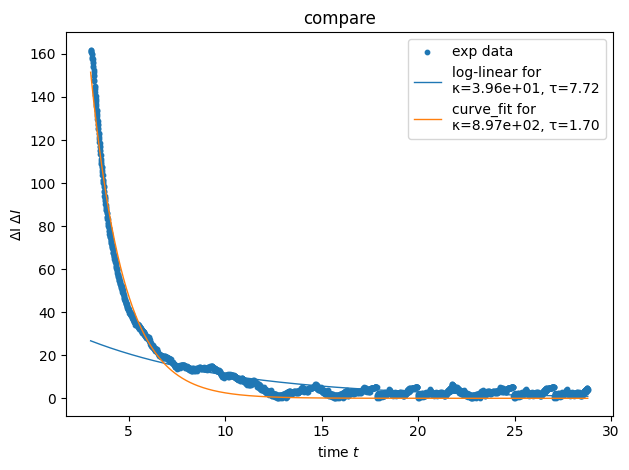

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 假设之前已经计算出了：
# t_fit, I_fit        # 用于拟合的数据点
# kappa_a, tau_a      # 方法 A 的拟合参数
# kappa_b, tau_b      # 方法 B 的拟合参数
# exp_decay 函数也已定义：

def exp_decay(t, kappa, tau):
    return kappa * np.exp(-t / tau)

# 生成用于画拟合曲线的细分时间点
t_plot = np.linspace(t_fit.min(), t_fit.max(), 500)

plt.figure()
# 画原始衰减数据
plt.scatter(t_fit, I_fit, label="data", s=10)

# 画方法 A 拟合曲线
plt.plot(t_plot,
         exp_decay(t_plot, kappa_a, tau_a),
         label=f"log-linear for \nκ={kappa_a:.2e}, τ={tau_a:.2f}",
         linewidth=1)

# 画方法 B 拟合曲线
plt.plot(t_plot,
         exp_decay(t_plot, kappa_b, tau_b),
         label=f"curve_fit for \nκ={kappa_b:.2e}, τ={tau_b:.2f}",
         linewidth=1)

plt.xlabel("time $t$")
plt.ylabel("current $\Delta I$")
plt.title("compare")
plt.legend()
plt.tight_layout()
plt.show()


# 5 个连续光脉冲由01编码组成，上述给出的是连续五个脉冲11111的弛豫模型，请给出00000到11111的总共32中脉冲对应的模型 

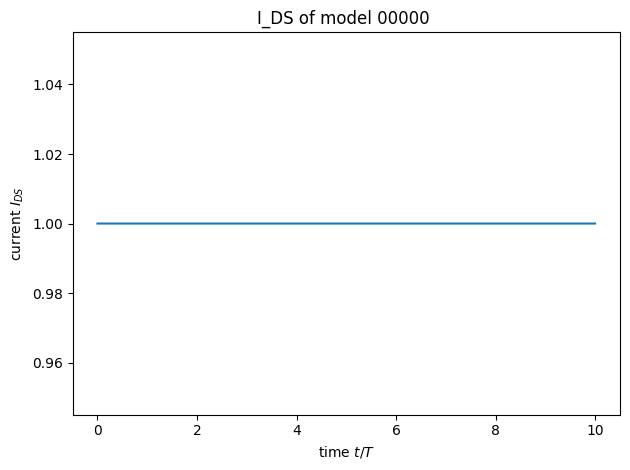

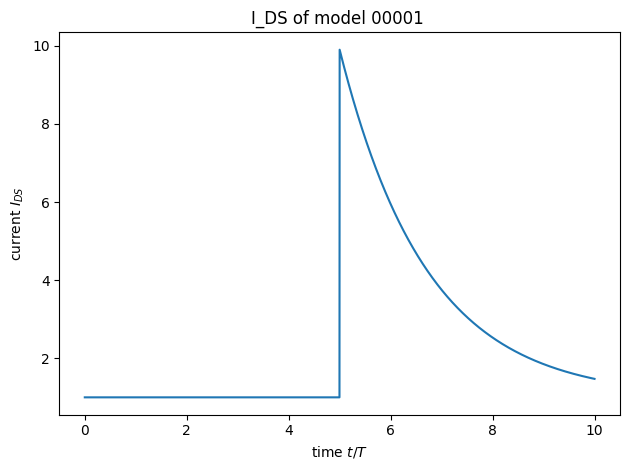

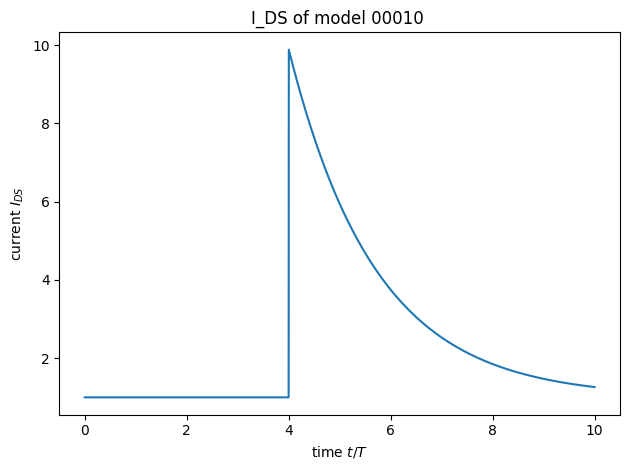

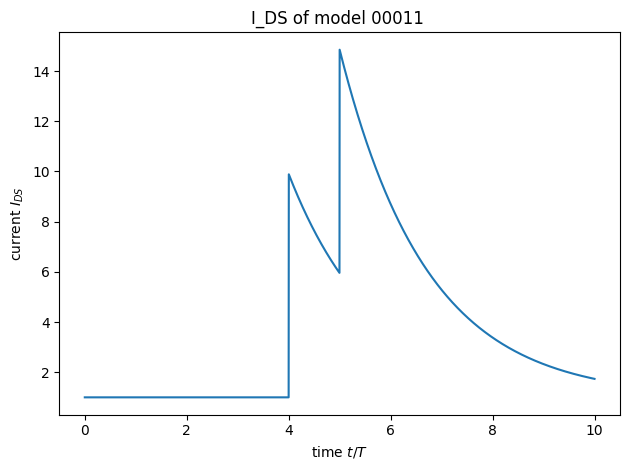

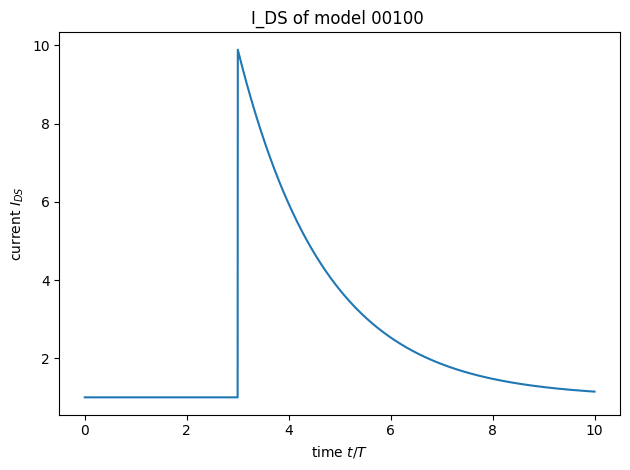

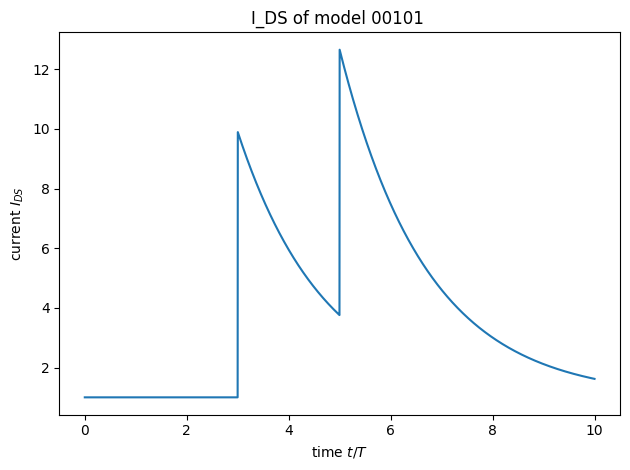

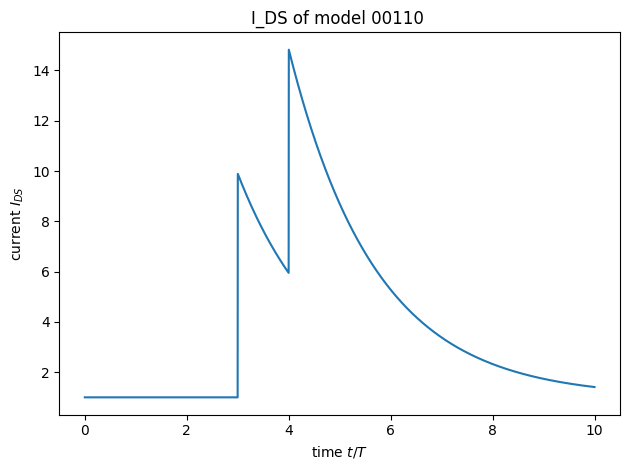

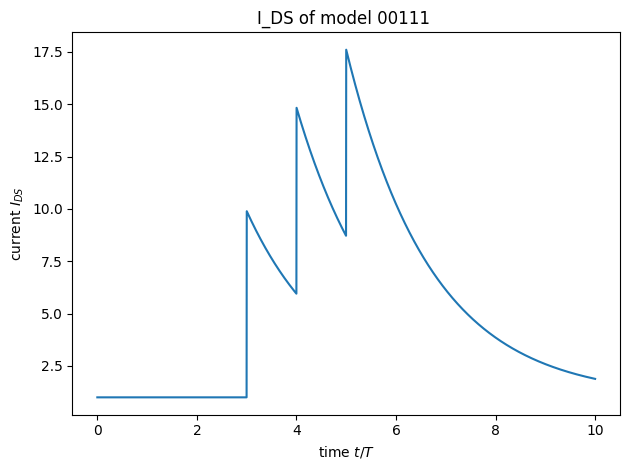

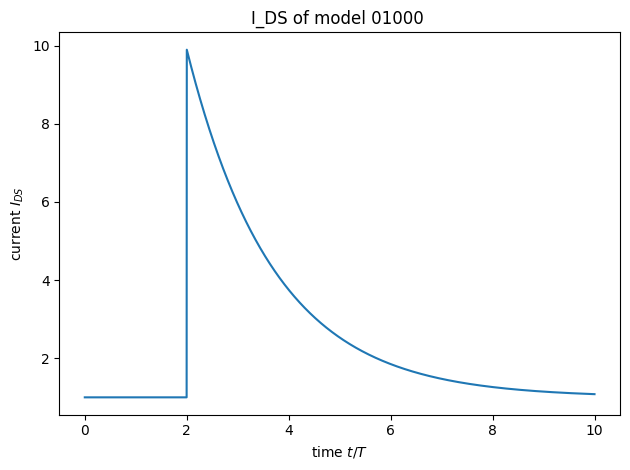

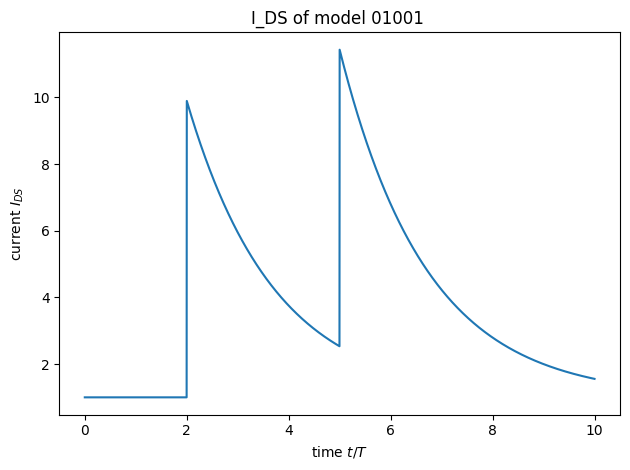

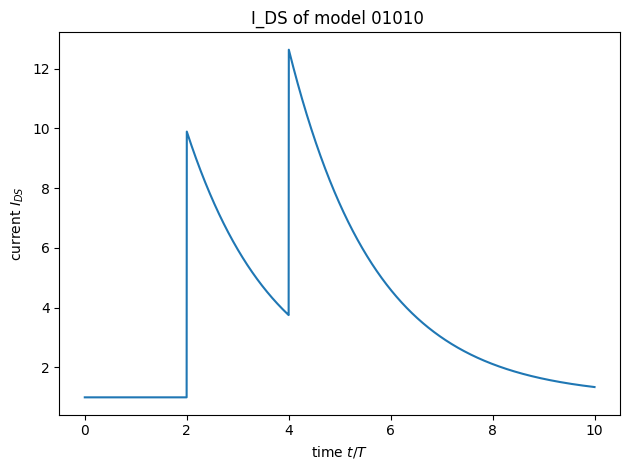

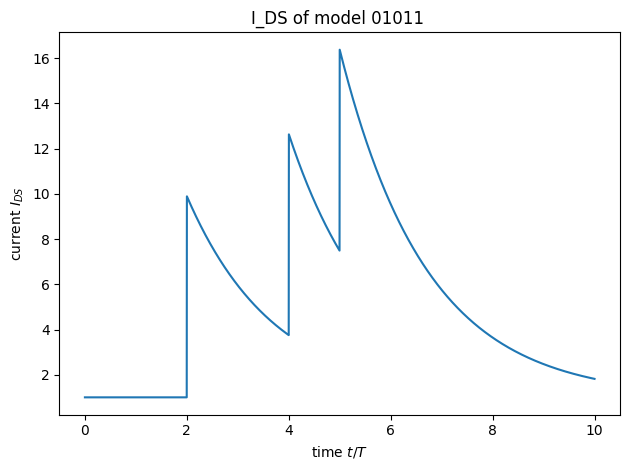

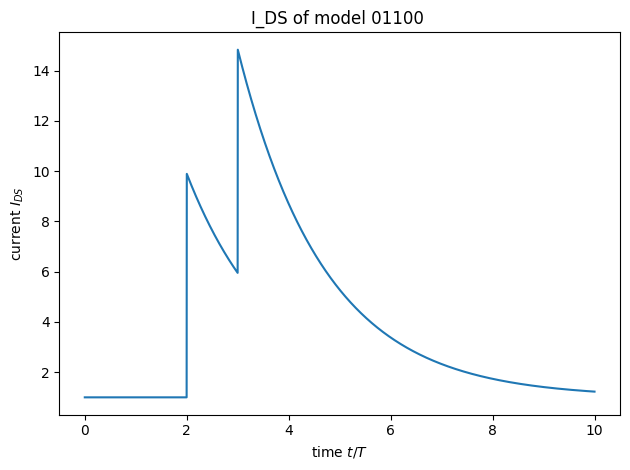

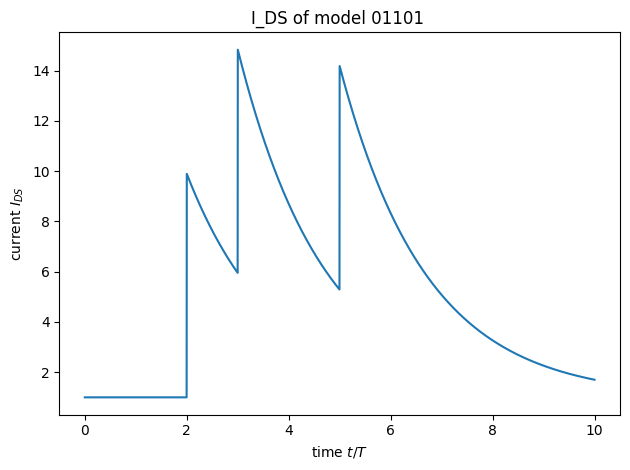

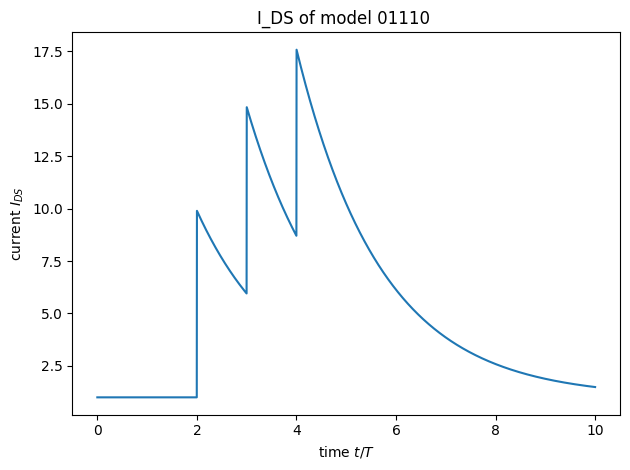

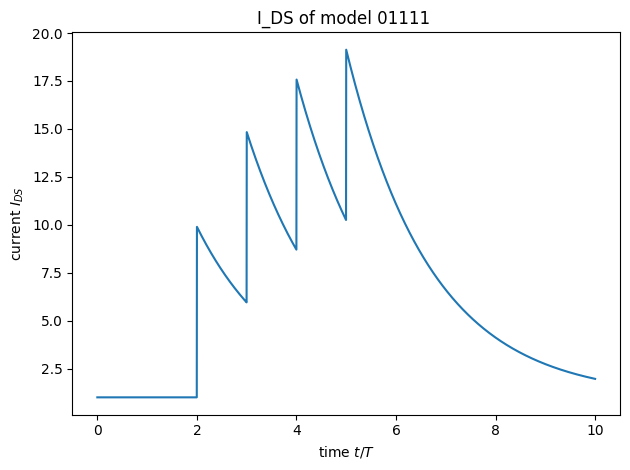

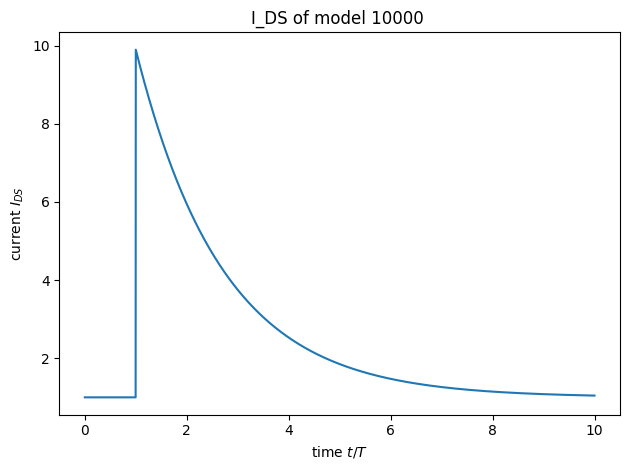

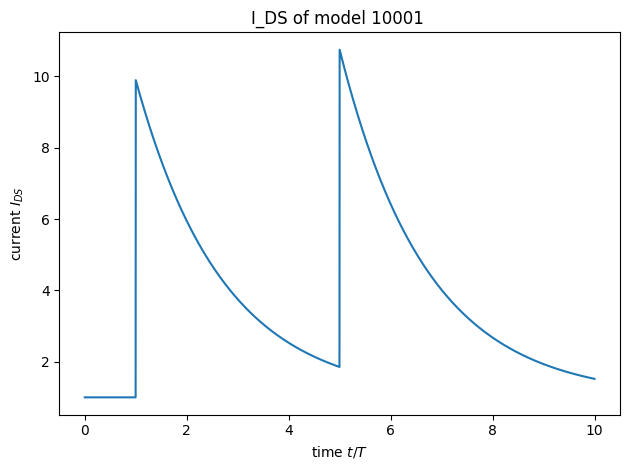

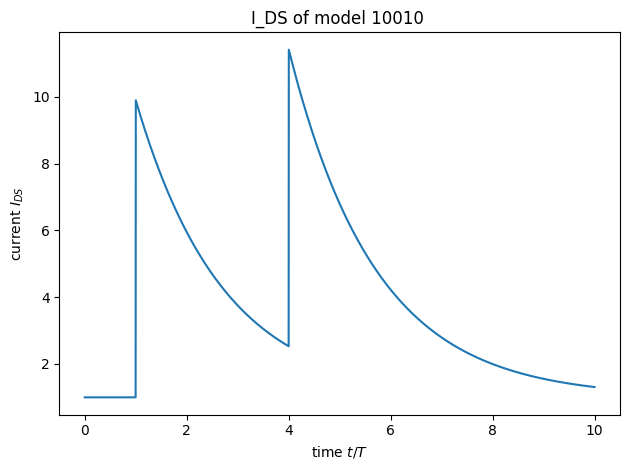

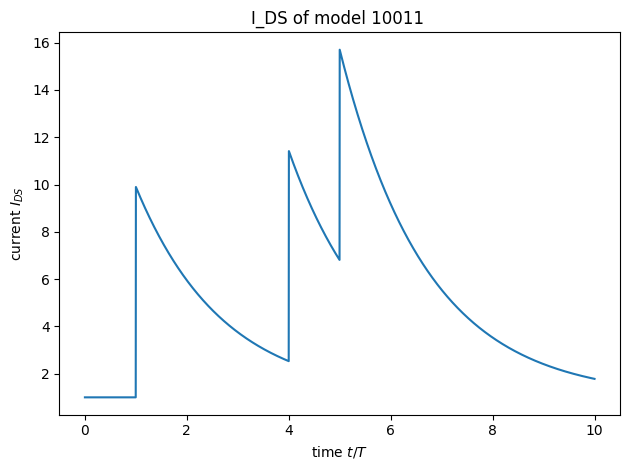

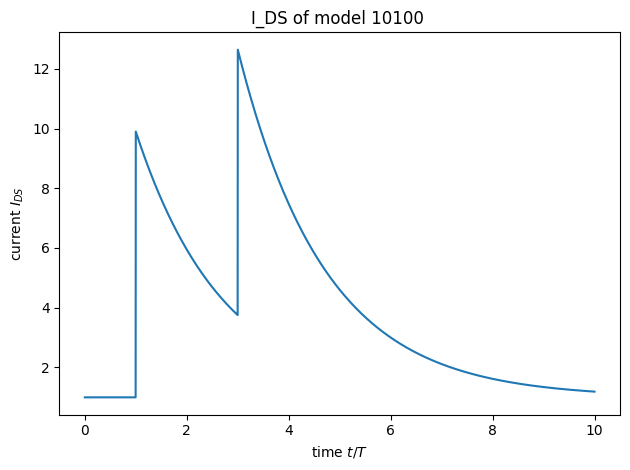

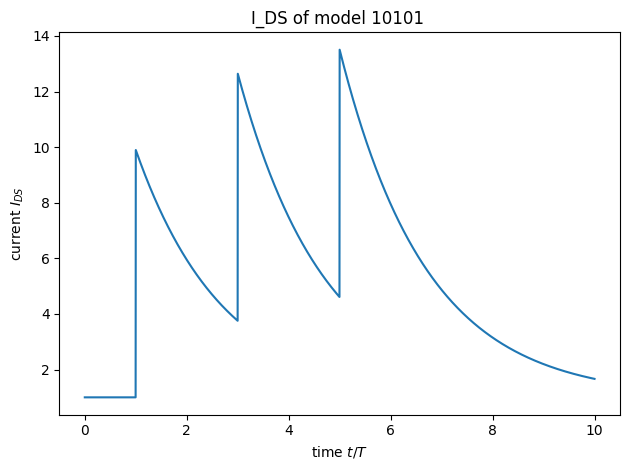

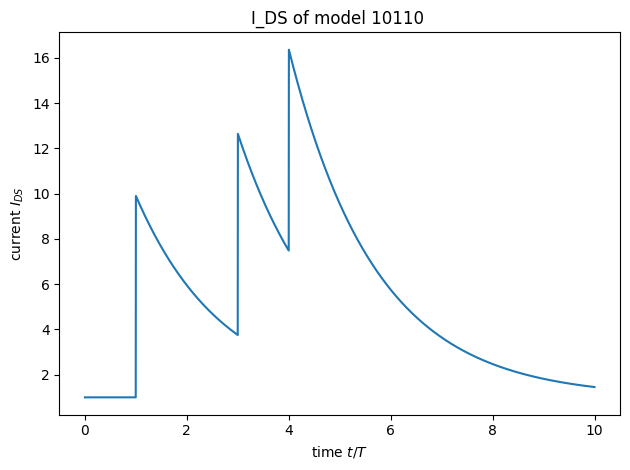

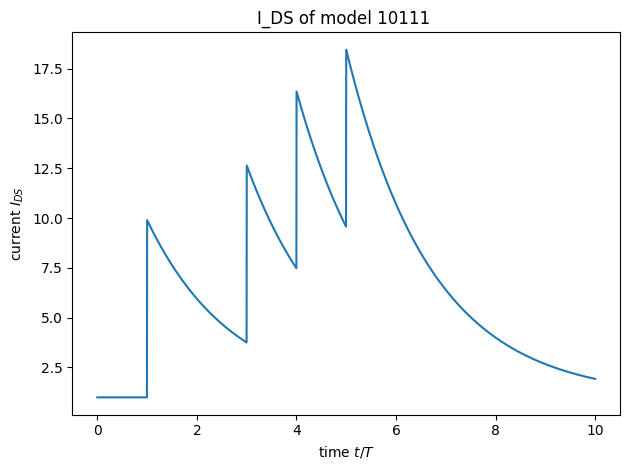

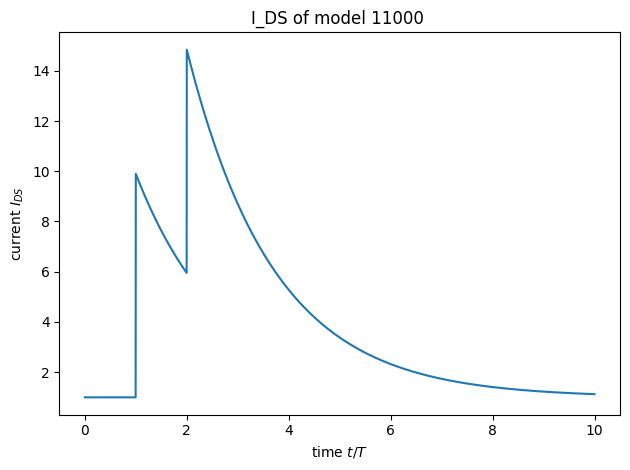

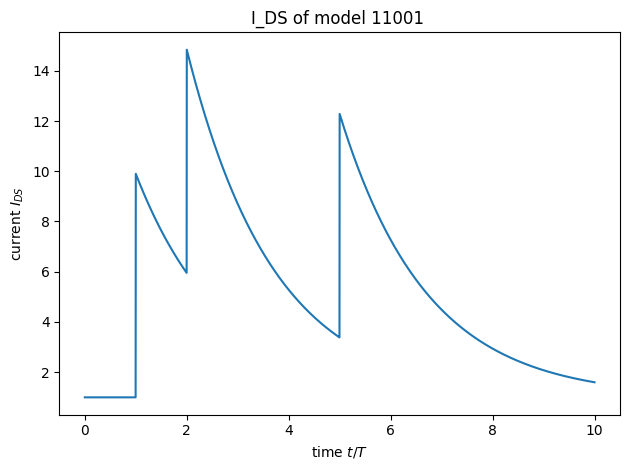

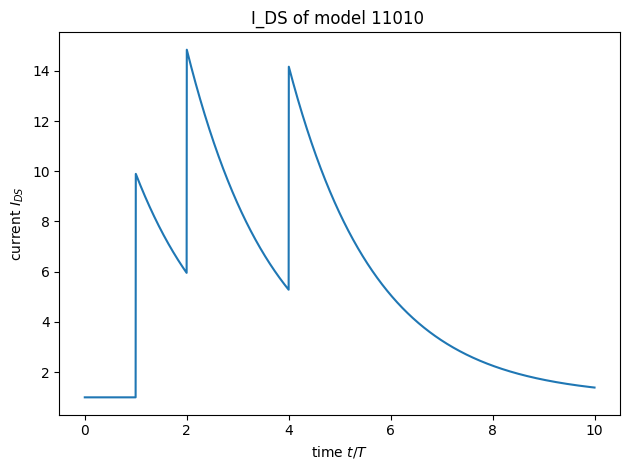

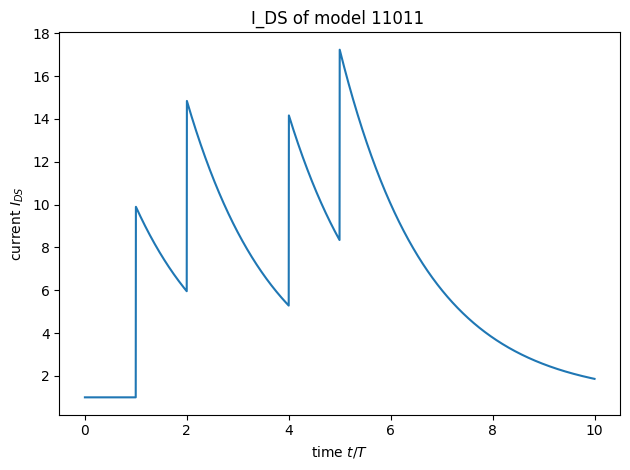

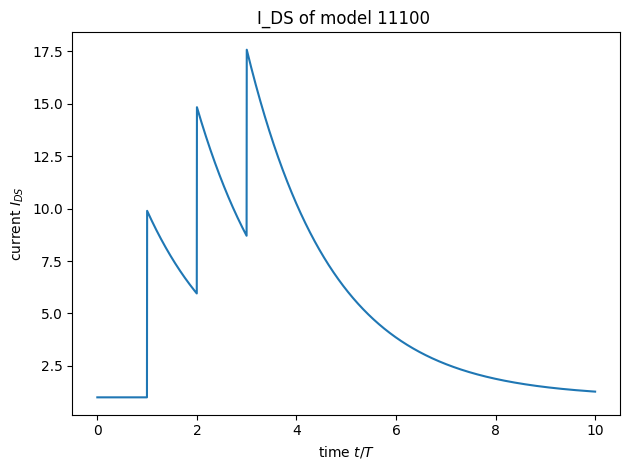

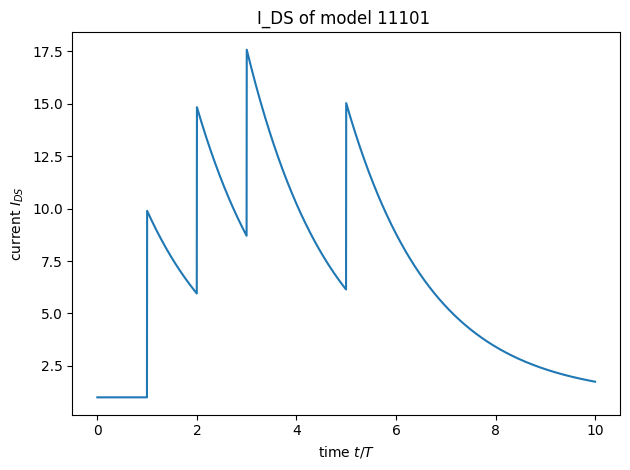

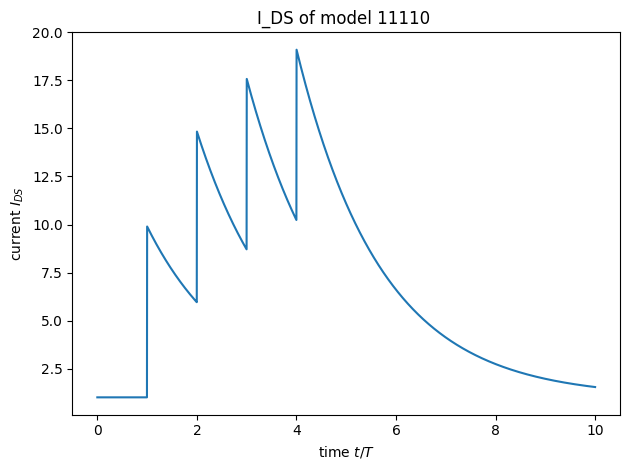

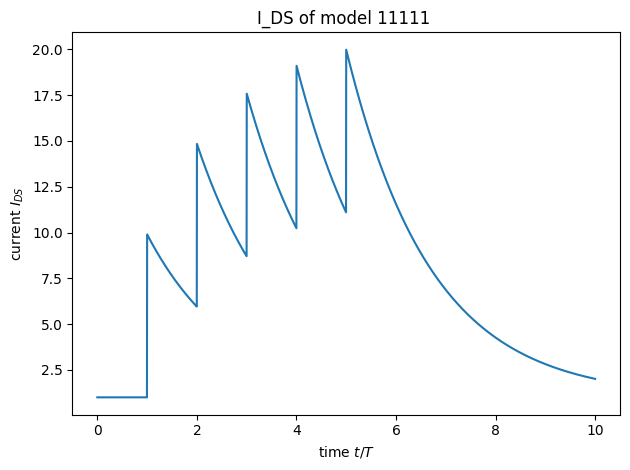

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# —— 参数设置 —— 
kappa = 8.9     # 单次脉冲电流增量
tau   = 1.704     # 弛豫时间常数
beta  = 1     # 拉伸指数
T     = 1      # 时间步长
I0    = 1     # 静态基线电流

t_pulses = [1,2,3,4,5]
# —— 时间向量 —— 
# 生成一个从 0 开始、到最后一脉冲时间再加 5（单位同脉冲间隔）的线性时间向量，共 2879 个采样点
t = np.linspace(0, t_pulses[-1] + 5, 2879)


# —— 生成所有 32 种 5-bit 模式 —— 
patterns = [''.join(p) for p in product('01', repeat=5)]

# —— 存储结果 —— 
results = {}  # dict: key=pattern, value=I_DS 数组

for pat in patterns:
    # 根据模式提取脉冲到达时刻（1 表示在该步有脉冲）
    pulse_times = [(i+1) for i, bit in enumerate(pat) if bit == '1']

    # 计算 I_DS(t) 曲线
    I_DS = np.zeros_like(t)
    for idx, t_n in enumerate(t):
        # 对每个已到来脉冲累加拉伸指数衰减响应
        delta_I = 0.0
        for pt in pulse_times:
            if t_n >= pt:
                delta_I += kappa * np.exp(-(((t_n - pt) * T) / tau) ** beta)
        I_DS[idx] = I0 + delta_I

    results[pat] = I_DS

    # —— 可选：为每个模式绘图 —— 
    plt.figure()
    plt.plot(t, I_DS)
    plt.title(f"I_DS of model {pat} ")
    plt.xlabel("time $t/T$")
    plt.ylabel("current $I_{DS}$")
    plt.tight_layout()
    plt.show()

# —— 最终，results 中保存了所有 32 种模式对应的输出电流曲线 —— 
# 例如查看 '10110' 模式：
# I_DS_10110 = results['10110']


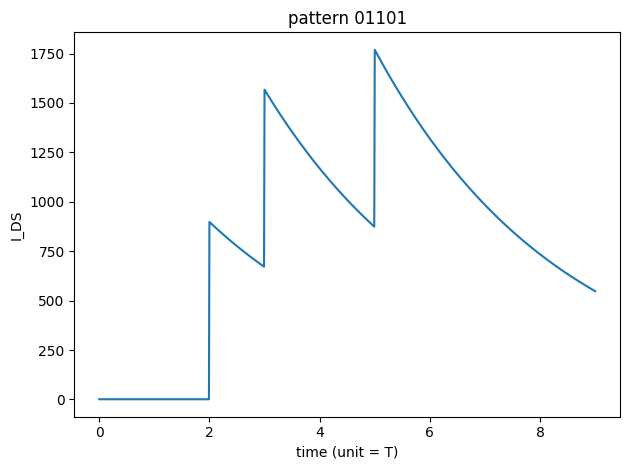

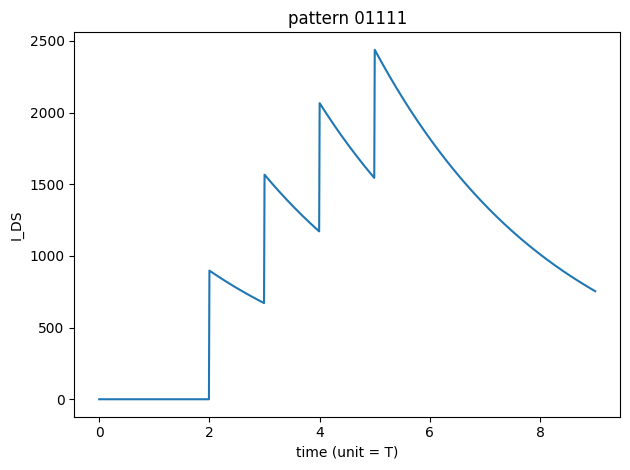

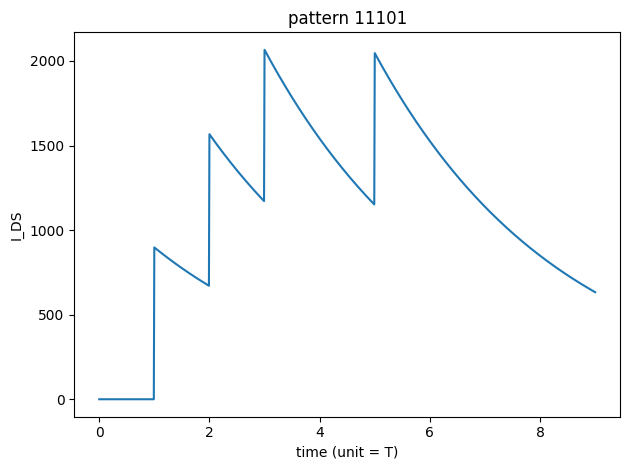

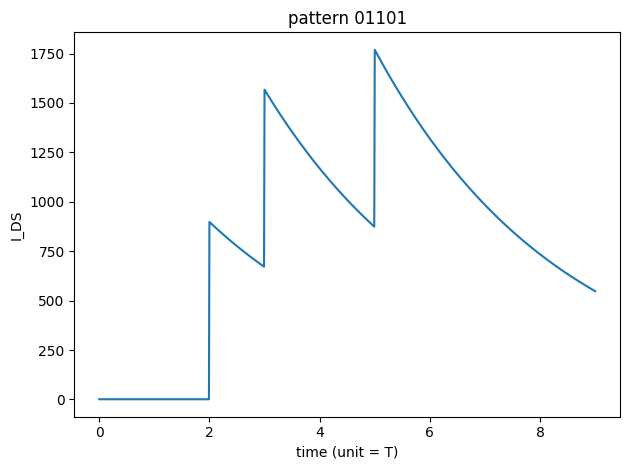

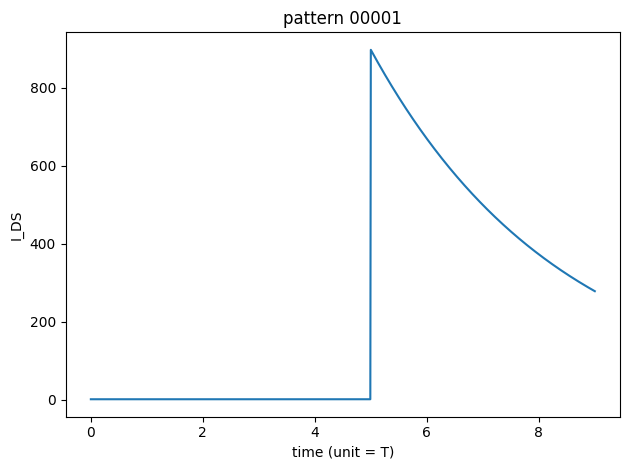

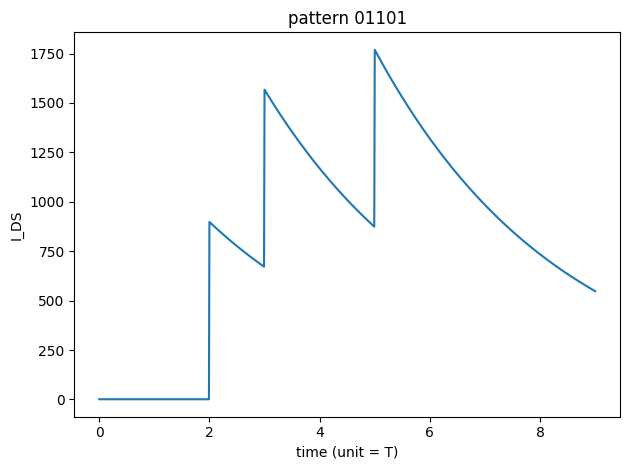

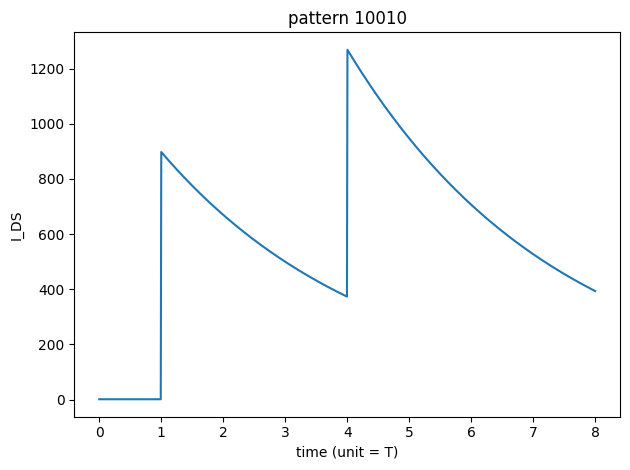

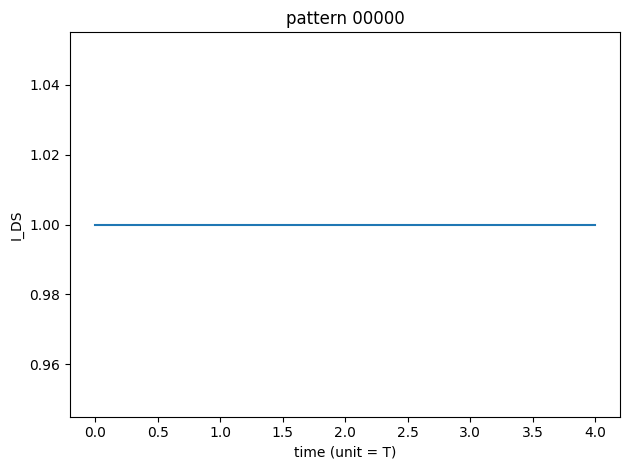

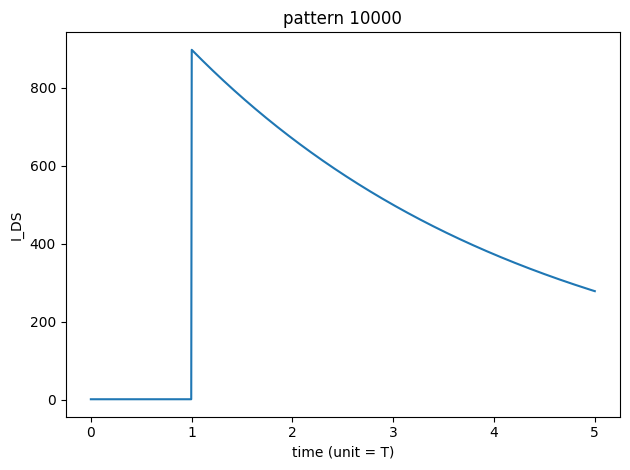

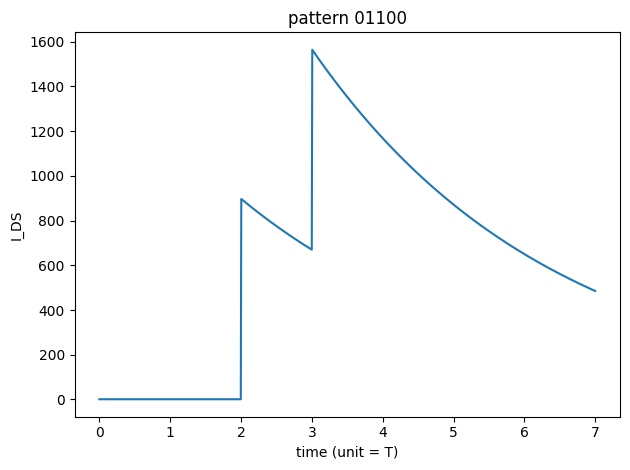

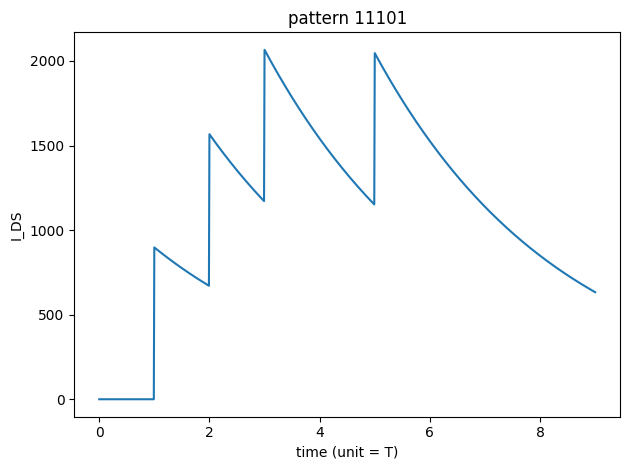

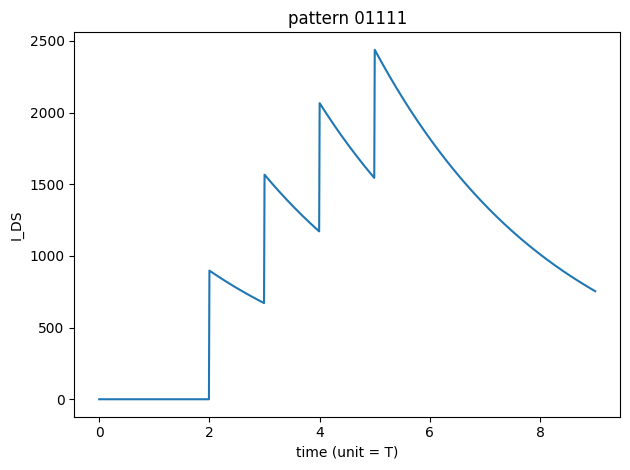

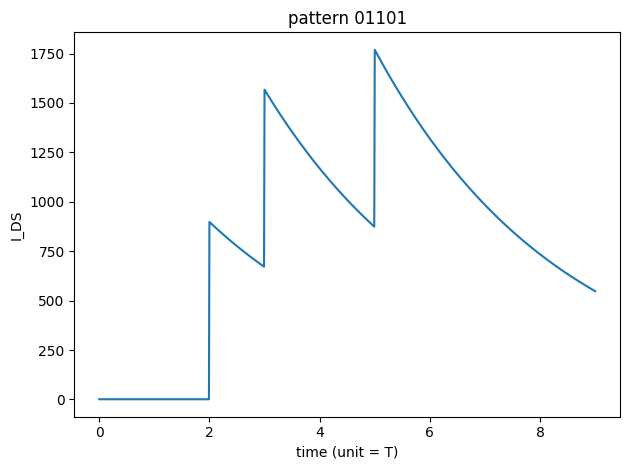

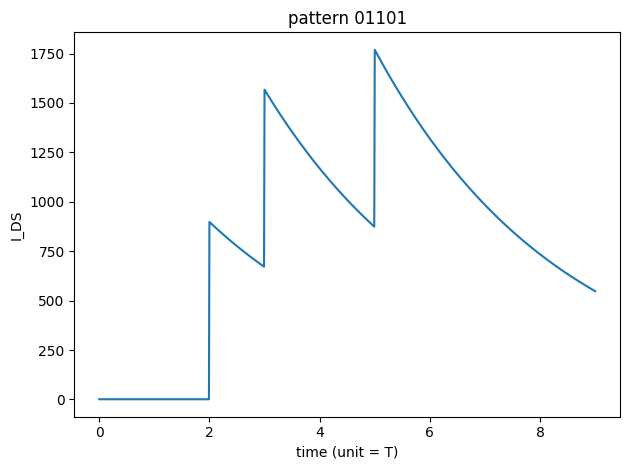

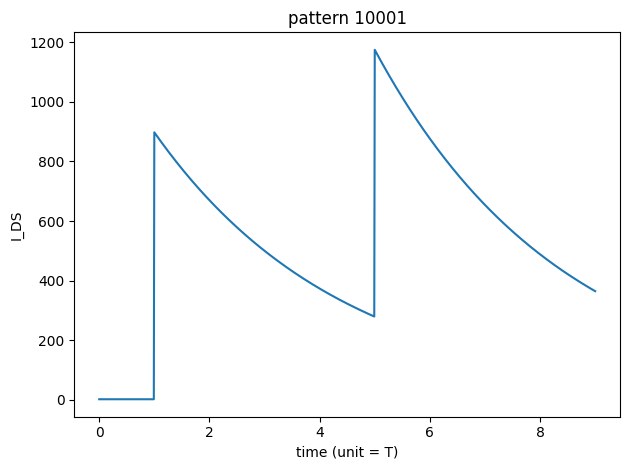

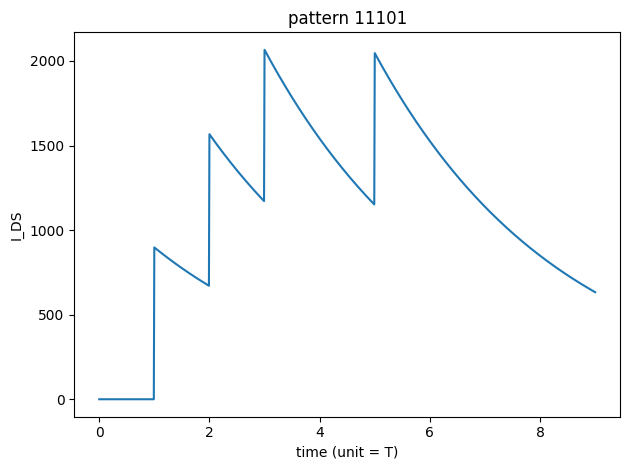

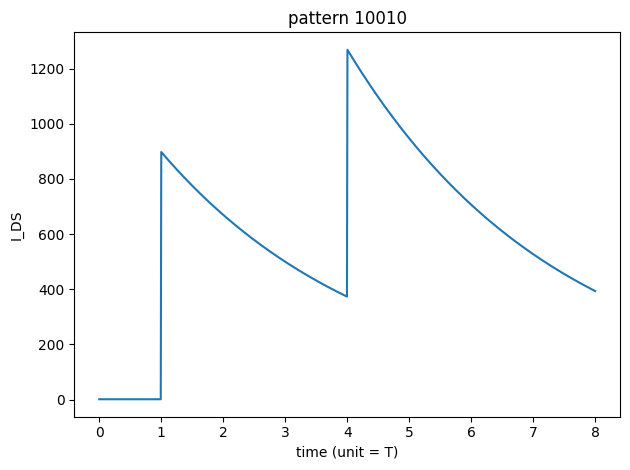

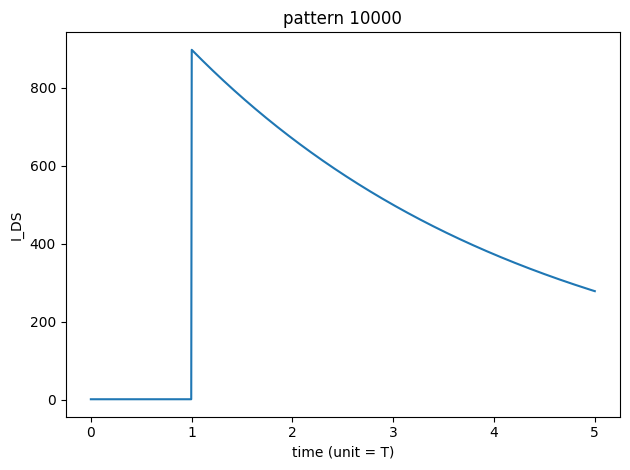

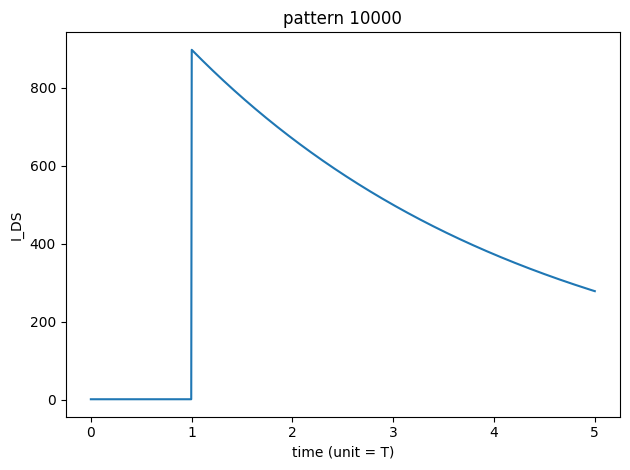

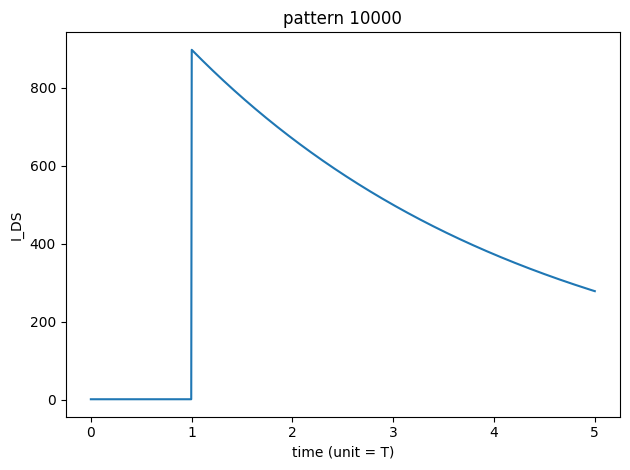

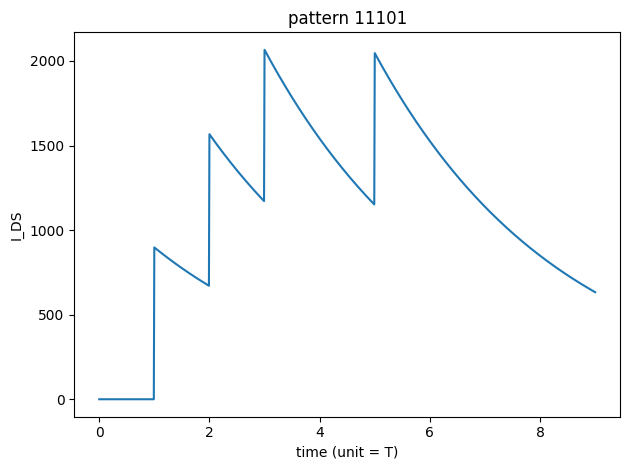

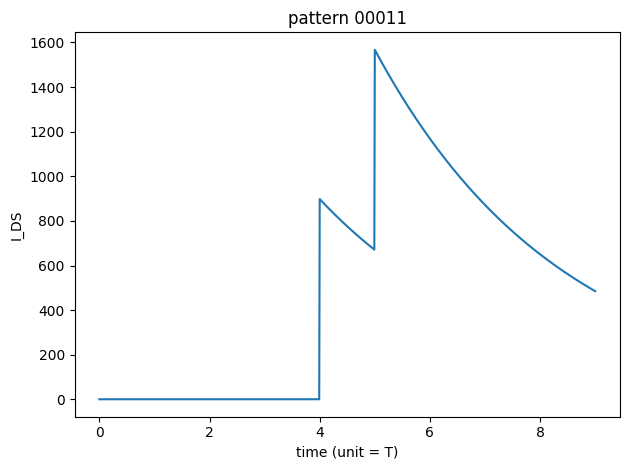

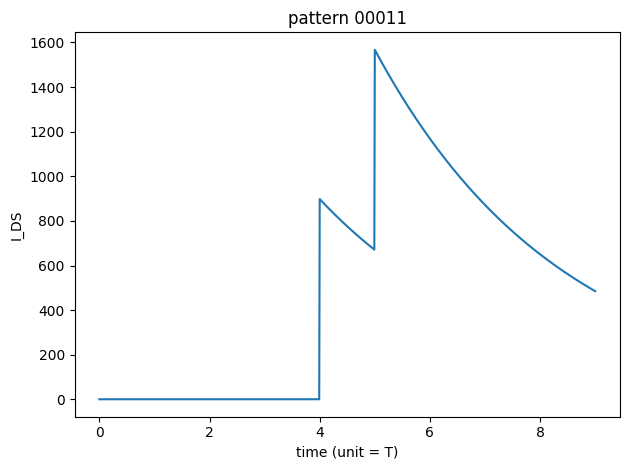

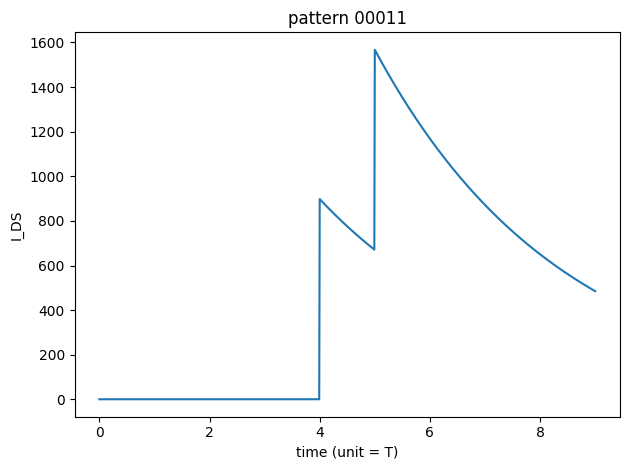

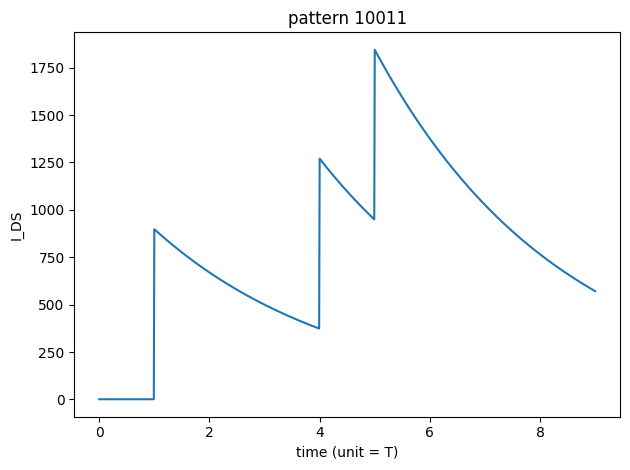

已生成文件 APPLE_end_values.csv


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ——— 1. 25 组 5-bit 脉冲模式（按你给出的顺序） ———
patterns = [
    "01101","01111","11101","01101","00001",
    "01101","10010","00000","10000","01100",
    "11101","01111","01101","01101","10001",
    "11101","10010","10000","10000","10000",
    "11101","00011","00011","00011","10011"
]

# ——— 2.  模型参数 ———
kappa = 897        # 单脉冲电流增量
tau   = 1.704      # 弛豫时间常数
beta  = 1          # 拉伸指数
T     = 0.5          # 脉冲间隔(时间步长)
I0    = 1          # 静态基线电流

# ——— 3. 结果容器 ———
curves      = {}            # key=pattern,  value=(t, I_DS)
end_records = []            # 保存最后脉冲+T 时刻的电流

for pat in patterns:
    # 3.1 该模式下脉冲到达时刻 (第 1-5 步的位置, 从 1 开始计数)
    pulse_times = [i+1 for i, bit in enumerate(pat) if bit == '1']

    # 3.2 时间轴：从 0 到 “最后脉冲+4T” — 取 1000 个采样点作示意
    last_pt  = pulse_times[-1] if pulse_times else 0      # 全 0 时 last_pt=0
    t_max    = last_pt + 4                               # 画到衰减差不多结束即可
    t        = np.linspace(0, t_max, 1000)

    # 3.3 计算 I_DS(t)
    I_DS = np.full_like(t, I0, dtype=float)
    for pt in pulse_times:
        I_DS += kappa * np.exp(-(((t - pt) * T) / tau) ** beta) * (t >= pt)  # Heaviside

    # 3.4 存曲线 (可根据需要再用)
    curves[pat] = (t, I_DS)

    # 3.5 取 “最后脉冲 + T” 时刻电流（目标时刻 t_target = last_pt + 1）
    t_target = last_pt + T
    I_target = I0 + sum(
        kappa * np.exp(-(((t_target - pt) * T) / tau) ** beta) for pt in pulse_times
    )
    end_records.append({"pattern": pat, "I_DS_lastPulsePlus1T": I_target})

    # 3.6 画图（如不想弹 25 张图，把下面三行注掉即可）
    plt.figure()
    plt.plot(t, I_DS)
    plt.title(f"pattern {pat}")
    plt.xlabel("time (unit = T)")
    plt.ylabel("I_DS")
    plt.tight_layout()
    plt.show()

# ——— 4. 把“最后脉冲 + 1T” 的电流写入 CSV ———
df_end = pd.DataFrame(end_records)
df_end.to_csv("APPLE_end_values.csv", index=False, float_format="%.6f")
print("已生成文件 APPLE_end_values.csv")
